# Week 7_Day 2: CIFAR-10 Classifier with CNN(Final Version)

### Imports & Setup

In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


### Dataset and Dataloader Setup

In [2]:
MEAN = (0.4914, 0.4822, 0.4465)
STD  = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

full_train_aug = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)

full_train_clean = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_test
)

train_size = int(0.9 * len(full_train_aug))
val_size = len(full_train_aug) - train_size
train_split, val_split = random_split(full_train_aug, [train_size, val_size])

train_ds = Subset(full_train_aug, train_split.indices)
val_ds   = Subset(full_train_clean, val_split.indices)

test_ds = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)

class_names = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

In [3]:
def make_loaders(batch_size: int):
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

### CNN Model

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, dropout: float = 0.2):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1   = nn.Linear(64 * 8 * 8, 256)
        self.drop  = nn.Dropout(dropout)
        self.fc2   = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))

        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        
        return x

### Training Utilities

**Training & Validation One Epoch**

In [5]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

**Training Multiple Epochs & Tracking**

In [6]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs: int):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_acc = -1.0
    best_state = None

    for epoch in range(epochs):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        va_loss, va_acc = evaluate(model, val_loader, criterion, device)

        train_losses.append(tr_loss)
        val_losses.append(va_loss)
        train_accs.append(tr_acc)
        val_accs.append(va_acc)

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f} | "
            f"Val Loss: {va_loss:.4f}, Val Acc: {va_acc:.4f}"
        )

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "best_val_acc": best_val_acc,
        "best_state": best_state
    }

**Plotting Training Curves**

In [7]:
def plot_curves(history):
    plt.figure()
    plt.plot(history["train_losses"], label="Train Loss")
    plt.plot(history["val_losses"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")
    plt.show()

    plt.figure()
    plt.plot(history["train_accs"], label="Train Acc")
    plt.plot(history["val_accs"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Curve")
    plt.show()

### Hyperparameter Tuning

**Experiment Function**

In [8]:
def run_experiment(lr, batch_size, dropout, epochs, device):
    train_loader, val_loader, _ = make_loaders(batch_size)

    model = SimpleCNN(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = fit(model, train_loader, val_loader, criterion, optimizer, device, epochs)

    return {
        "lr": lr,
        "batch_size": batch_size,
        "dropout": dropout,
        "best_val_acc": history["best_val_acc"],
        "best_state": history["best_state"]
    }

**Tuning Grid Loop & Results Table**

In [9]:
lrs = [1e-2, 1e-3, 1e-4]
batch_sizes = [32, 64]
dropouts = [0.2, 0.5]
EPOCHS_TUNE = 10

results = []
best_run = None

for lr in lrs:
    for bs in batch_sizes:
        for do in dropouts:
            out = run_experiment(lr, bs, do, EPOCHS_TUNE, device)
            results.append({
                "lr": out["lr"],
                "batch_size": out["batch_size"],
                "dropout": out["dropout"],
                "best_val_acc": out["best_val_acc"]
            })

            if (best_run is None) or (out["best_val_acc"] > best_run["best_val_acc"]):
                best_run = out

df_results = pd.DataFrame(results).sort_values(by="best_val_acc", ascending=False)
df_results

Epoch 1/10 | Train Loss: 2.1790, Train Acc: 0.2157 | Val Loss: 1.7930, Val Acc: 0.2454
Epoch 2/10 | Train Loss: 1.8841, Train Acc: 0.2475 | Val Loss: 1.6758, Val Acc: 0.3460
Epoch 3/10 | Train Loss: 1.7489, Train Acc: 0.3302 | Val Loss: 1.5568, Val Acc: 0.4210
Epoch 4/10 | Train Loss: 1.6439, Train Acc: 0.3854 | Val Loss: 1.4117, Val Acc: 0.4900
Epoch 5/10 | Train Loss: 1.5776, Train Acc: 0.4179 | Val Loss: 1.3589, Val Acc: 0.5148
Epoch 6/10 | Train Loss: 1.5334, Train Acc: 0.4326 | Val Loss: 1.3372, Val Acc: 0.5252
Epoch 7/10 | Train Loss: 1.4886, Train Acc: 0.4549 | Val Loss: 1.2710, Val Acc: 0.5268
Epoch 8/10 | Train Loss: 1.4526, Train Acc: 0.4705 | Val Loss: 1.2060, Val Acc: 0.5774
Epoch 9/10 | Train Loss: 1.4241, Train Acc: 0.4851 | Val Loss: 1.1910, Val Acc: 0.5808
Epoch 10/10 | Train Loss: 1.4021, Train Acc: 0.4978 | Val Loss: 1.1488, Val Acc: 0.6018
Epoch 1/10 | Train Loss: 2.3485, Train Acc: 0.1286 | Val Loss: 2.1327, Val Acc: 0.1782
Epoch 2/10 | Train Loss: 2.0665, Train Acc

,lr,batch_size,dropout,best_val_acc
6,0.0010,64,0.2,0.7236
4,0.0010,32,0.2,0.7222
8,0.0001,32,0.2,0.7060
10,0.0001,64,0.2,0.7048
9,0.0001,32,0.5,0.6832
7,0.0010,64,0.5,0.6794
5,0.0010,32,0.5,0.6788
11,0.0001,64,0.5,0.6718
2,0.0100,64,0.2,0.6266
0,0.0100,32,0.2,0.6018


### Final Training

Best config: {'lr': 0.001, 'batch_size': 64, 'dropout': 0.2}
Epoch 1/30 | Train Loss: 1.5861, Train Acc: 0.4172 | Val Loss: 1.3289, Val Acc: 0.5148
Epoch 2/30 | Train Loss: 1.3059, Train Acc: 0.5270 | Val Loss: 1.0647, Val Acc: 0.6102
Epoch 3/30 | Train Loss: 1.1863, Train Acc: 0.5742 | Val Loss: 0.9946, Val Acc: 0.6402
Epoch 4/30 | Train Loss: 1.1259, Train Acc: 0.5992 | Val Loss: 0.9712, Val Acc: 0.6604
Epoch 5/30 | Train Loss: 1.0753, Train Acc: 0.6189 | Val Loss: 0.9101, Val Acc: 0.6716
Epoch 6/30 | Train Loss: 1.0342, Train Acc: 0.6314 | Val Loss: 0.9424, Val Acc: 0.6656
Epoch 7/30 | Train Loss: 1.0002, Train Acc: 0.6445 | Val Loss: 0.8536, Val Acc: 0.6942
Epoch 8/30 | Train Loss: 0.9792, Train Acc: 0.6554 | Val Loss: 0.8192, Val Acc: 0.7112
Epoch 9/30 | Train Loss: 0.9527, Train Acc: 0.6634 | Val Loss: 0.8124, Val Acc: 0.7184
Epoch 10/30 | Train Loss: 0.9316, Train Acc: 0.6722 | Val Loss: 0.7925, Val Acc: 0.7190
Epoch 11/30 | Train Loss: 0.9129, Train Acc: 0.6795 | Val Loss: 0.81

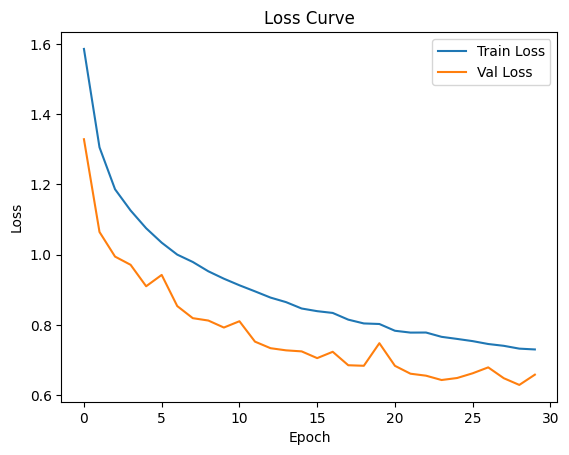

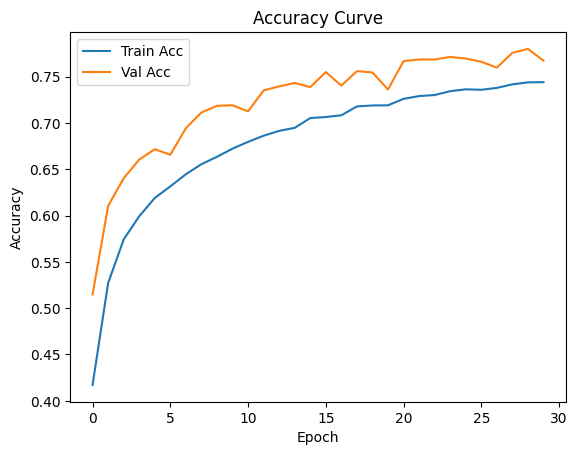

Best Val Acc: 0.7798


In [10]:
BEST_LR = float(best_run["lr"])
BEST_BS = int(best_run["batch_size"])
BEST_DO = float(best_run["dropout"])

print("Best config:", {"lr": BEST_LR, "batch_size": BEST_BS, "dropout": BEST_DO})

train_loader, val_loader, test_loader = make_loaders(BEST_BS)

model = SimpleCNN(dropout=BEST_DO).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=BEST_LR)

EPOCHS_FINAL = 30
history = fit(model, train_loader, val_loader, criterion, optimizer, device, EPOCHS_FINAL)

model.load_state_dict(history["best_state"])
model.to(device)

plot_curves(history)
print("Best Val Acc:", history["best_val_acc"])

### Evaluation

In [11]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Test Loss: 0.6313 | Test Acc: 0.7803


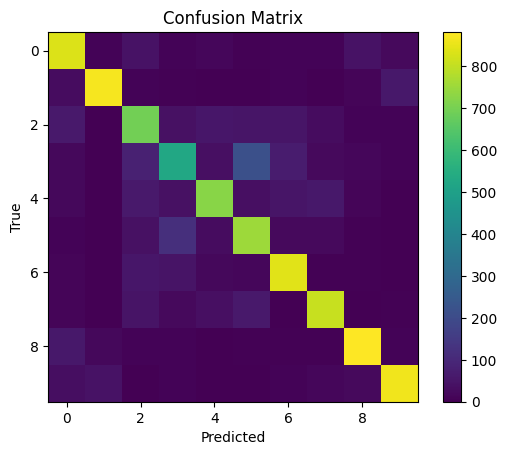

              precision    recall  f1-score   support

    airplane       0.77      0.83      0.80      1000
  automobile       0.91      0.87      0.89      1000
        bird       0.67      0.69      0.68      1000
         cat       0.64      0.53      0.58      1000
        deer       0.79      0.72      0.75      1000
         dog       0.66      0.75      0.70      1000
        frog       0.79      0.84      0.82      1000
       horse       0.82      0.81      0.82      1000
        ship       0.88      0.88      0.88      1000
       truck       0.88      0.86      0.87      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



In [12]:
@torch.no_grad()
def collect_predictions(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []

    for images, labels in loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu()

        all_preds.append(preds)
        all_labels.append(labels)

    return torch.cat(all_preds), torch.cat(all_labels)

all_preds, all_labels = collect_predictions(model, test_loader, device)

cm = confusion_matrix(all_labels, all_preds)
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

print(classification_report(all_labels, all_preds, target_names=class_names))

### Save Model and Weights

In [13]:
torch.save(model.state_dict(), "cifar10_cnn_best.pth")
df_results.to_csv("tuning_results.csv", index=False)
print("Saved: cifar10_cnn_best.pth, tuning_results.csv")

Saved: cifar10_cnn_best.pth, tuning_results.csv
